In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

**Import data**

In [2]:
df = pd.read_excel('Fire.xlsx')

In [3]:
df

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
2,1,gasoline,10,96,2.6,70,1
3,1,gasoline,10,96,3.2,68,1
4,1,gasoline,10,109,4.5,67,1
...,...,...,...,...,...,...,...
17437,7,lpg,190,86,2.2,5,0
17438,7,lpg,190,84,2.0,4,0
17439,7,lpg,190,80,1.5,3,0
17440,7,lpg,190,76,0.4,2,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17442 entries, 0 to 17441
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SIZE       17442 non-null  int64  
 1   FUEL       17442 non-null  object 
 2   DISTANCE   17442 non-null  int64  
 3   DESIBEL    17442 non-null  int64  
 4   AIRFLOW    17442 non-null  float64
 5   FREQUENCY  17442 non-null  int64  
 6   STATUS     17442 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 954.0+ KB


In [5]:
df.describe()

,SIZE,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
count,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000
mean,3.411765,100.000000,96.379142,6.975634,31.611111,0.497821
std,1.750977,54.773826,8.164096,4.736169,20.939149,0.500010
min,1.000000,10.000000,72.000000,0.000000,1.000000,0.000000
25%,2.000000,50.000000,90.000000,3.200000,14.000000,0.000000
50%,3.000000,100.000000,95.000000,5.800000,27.500000,0.000000
75%,5.000000,150.000000,104.000000,11.200000,47.000000,1.000000
max,7.000000,190.000000,113.000000,17.000000,75.000000,1.000000


**Convert type column 'FUEL' to int**

In [6]:
from sklearn.preprocessing import OrdinalEncoder

label_encoder = OrdinalEncoder()

df['FUEL'] = label_encoder.fit_transform(df[['FUEL']])

**Split data to x and y**

In [7]:
y = df.pop('STATUS')
x = df.copy()

<AxesSubplot:>

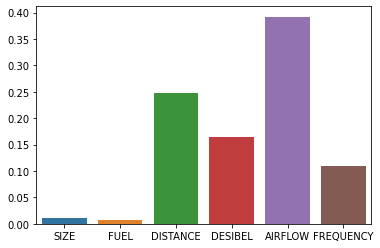

In [8]:
from sklearn.feature_selection import mutual_info_classif

imp = mutual_info_classif(x,y)

sns.barplot(x=x.columns, y=imp)

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1) 
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.2, random_state=1)

In [10]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)
x_val = ss.fit_transform(x_val)

**Model**

In [11]:
from tensorflow.keras import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import GridSearchCV

def create_model():
    model = Sequential()

    model.add(layers.Input(shape=(6,)))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [12]:
%%capture 
np.random.seed(1)

test_model = KerasClassifier(build_fn=create_model)

batch_size = [32,64,128]
epochs = [50,100,150]

param_grid = dict(batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=test_model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x, y)

In [14]:
grid_result.best_params_

{'batch_size': 32, 'epochs': 150}

In [15]:
model = create_model()

history = model.fit(x_train, y_train, epochs=150, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/150
349/349 [==============================] - 1s 1ms/step - loss: 0.7011 - accuracy: 0.6067 - val_loss: 0.4982 - val_accuracy: 0.8166
Epoch 2/150
349/349 [==============================] - 0s 836us/step - loss: 0.4114 - accuracy: 0.8720 - val_loss: 0.3561 - val_accuracy: 0.8746
Epoch 3/150
349/349 [==============================] - 0s 741us/step - loss: 0.3159 - accuracy: 0.8835 - val_loss: 0.2941 - val_accuracy: 0.8760
Epoch 4/150
349/349 [==============================] - 0s 801us/step - loss: 0.2712 - accuracy: 0.8889 - val_loss: 0.2638 - val_accuracy: 0.8850
Epoch 5/150
349/349 [==============================] - 0s 766us/step - loss: 0.2476 - accuracy: 0.8937 - val_loss: 0.2468 - val_accuracy: 0.8879
Epoch 6/150
349/349 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.89 - 0s 809us/step - loss: 0.2328 - accuracy: 0.8977 - val_loss: 0.2354 - val_accuracy: 0.8900
Epoch 7/150
349/349 [==============================] - 0s 755us/step - loss: 0.2228 - accu

In [16]:
model.evaluate(x_test, y_test)

110/110 [==============================] - 0s 640us/step - loss: 0.1678 - accuracy: 0.9243


[0.16778433322906494, 0.9243336319923401]

**Model evaluation**

(0.0, 1.0)

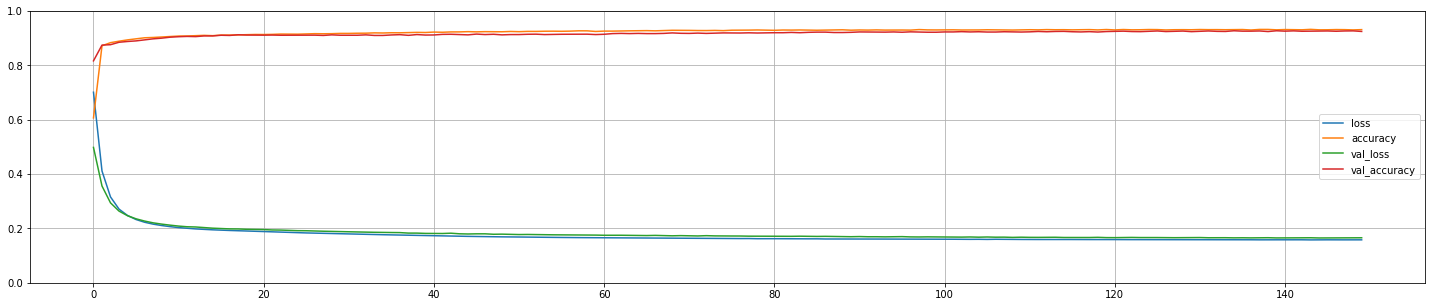

In [17]:
pd.DataFrame(history.history).plot(figsize=(25,5))
plt.grid(True)
plt.gca().set_ylim(0,1)

<AxesSubplot:>

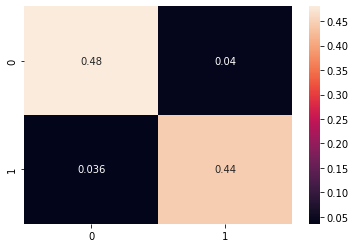

In [18]:
from sklearn.metrics import confusion_matrix

y_true = np.array(y_test).reshape([len(y_test), 1])
y_pred = [1 if x>.5 else 0 for x in model.predict(x_test)]

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm/np.sum(cm), annot=True)